<h1 align=center> Quad Tree (درخت 4-گانه) <h1>

<div dir=rtl>

ایده جستحوی باینری رو یادت میاد؟ ایده درخت باینری رو چطور؟

اگر یادت باشه، میدونی که جیزی که توی درخت باینری ذخیره میکردیم، داده های تک بعدی بودن
( مثل عدد )

---------------

### اما برای داده های "چند بعدی" چطور؟
 
اگر بخوایم به طور مثال اعلاعاتی رو به همراه مختصاتشون روی نقشه ذخیره کنیم، چطوری بعدا پیداشون کنیم؟

*خب دوست من، اینجا جاییه که درخت 4 گانه وارد میشود!*

> البته درخت 4 گانه برای مختصات دو بعدیه، برای 3 بعدی از یک تیپ دیگه استفاده میکننه به نام درخت 8 گانه ولی کلیت کار همینه


![intro](./intro.png "Title")

<div dir="rtl">

## ایده
ایده این ساختمان داده اینه که اگر تعداد "چیز"ها توی یک قسمت به بیشنتر از حد معینی رسید،
بیا اون قسمت رو به 4 تا زیر مجموعه تقسیم کن

برای جستجو اش هم، از ریشه شروع میکنه و هر شاخه ای که مساحتش با مساحت خواسته شده تداخل داشت،
میگرده، این کار رو تا زمانی انجام میده که اون ناحیه دیگه زیرمجموعه نداشته باشه،
اون موقع میاد محتویات اون ناحیه ( که شامل همون "چیز" ها میشه) رو میگرده تا ببینه کدوما توی مساخت خواسته شده هستن

در خصوص حذف کردن از این درخت، روش های زیادی وجود داره ولی تا جایی که ممکنه سعی میکنن از درخت چیزی حذف نکنن چون الگوریتم هاش ی مقدار پیچیده است و من بهش نمیپردازم



-------------
<div dir=rtl>

## کد
اول، ی سریع چیزا رو تعریف کردم که بعدا بهش احتیاج پیدا میکنیم

In [1]:
from dataclasses import *

# =================================================== Basic Classes


@dataclass
class Range:
    start: float
    end: float

    def size(r):
        return r.end - r.start

    def insersects(r1, r2) -> bool:
        """
        determines wether the ranges `r1` & `r2` have intersection or not

        HAVING INTERSECTION:
        A: (0..4) ~ (2..6)
            +---(2)---+
        +--(1)---+

        B: (2..6) ~ (0..4)
        +---(2)---+
            +--(1)---+

        C: (2..3) ~ (0..6)
        +-----(2)------+
            +-(1)-+

        D: (0..6) ~ (2..3)
            +-(2)-+
        +-----(1)------+


        NO INTERSECTION:
        E: (0..4) ~ (5..9)
                    +--(2)---+
        +--(1)--+

        F: (5..9) ~ (0..4)
        +--(2)--+
                    +--(1)--+
        """

        s = min(r1.end, r2.end) - max(r1.start, r2.start)
        return (s > 0) and (s <= r1.size()) and (s <= r2.size())


@dataclass
class Point:
    x: float
    y: float


@dataclass
class Geometry:
    """
    mimics a rectangle
    """
    x: float
    y: float
    w: float
    h: float

    def intersects(g1, g2) -> bool:
        """
        checks wheter the 2 rectangle `g1` & `g2` intersects with
        each other or not
        """

        ix = Range(g1.x, g1.x + g1.w).insersects(Range(g2.x, g2.x + g2.w))
        iy = Range(g1.y, g1.y + g1.h).insersects(Range(g2.y, g2.y + g2.h))

        return (ix and iy)

    def contains(g, p: Point) -> bool:
        """
        checks wether point `p` is in the area of rectangle `g` or not
        """
        return (
            (p.x >= g.x and p.x <= (g.x + g.w)) and
            (p.y >= g.y and p.y <= (g.y + g.h)))



<div dir=rtl>

**توضیح کد های بالا**:
1. **کلاس Range**:
  این کلاس یک بازه رو در فضای تک بعدی مشخص میکنه که 
  شامل دو تا متد میشه
  
   - **متد len:**
    این متد اندازه بازه رو برمیگردونه -
    که میشه تفاضل آخر و اول بازه

   - **متد intersects:**
    این متد دوتا بازه میگیره و مشخص میکنه که آیا این دوتا باهم تداخل دارن یا نه

2. **کلاس Point:**
    این کلاس یک نقطه توی دستکاه مختصات دو بعدی رو نمایندگی میکنه

3. **کلاس Geometry:**
    این کلاس یک مسطتیل رو نمایندگی میکنه و دو تا متد داره

    - **متد intersects:**
        دو تا مستطیل میگیره و مشخص میکنه آیا اینا باهم تداخل دارن یا نه

    - **متد contains:**
        ی مستطیل میگیره و ی نقطه و مشخص میکنه که آیا اون نطقه توی مسطیل هست یا نه
        

In [2]:
@dataclass
class Entry:
    """
    this class is used as "main thing" in the QuadSpace
    """
    id: int
    location: Point


@dataclass
class QuadNode:
    level: int
    geometry: Geometry
    nodes: list
    entries: list

    def which_quadrant(qn, p: Point) -> int:
        """
        with assumming point `p` intersects with QuadNode `qn`,
        determines the index of quadrant (sub QuadNode) in which `p` 
        belongs to
        """

        xMid = qn.geometry.x + qn.geometry.w/2
        yMid = qn.geometry.y + qn.geometry.h/2

        if p.x < xMid:
            if p.y < yMid:
                return 0
            else:
                return 1
        else:
            if p.y < yMid:
                return 2
            else:
                return 3

    def is_leaf(qn) -> bool:
        return len(qn.nodes) == 0



<div dir=rtl>

**توضیح کد های بالا**:
1. **کلاس Entry**:
    این کلاس به عناون المان اصلی ما توی درخت 4-گانه استفاده میشه

2. **کلاس QuadNode**:
    این کلاس هر گره از درخت 4 گانه رو مشخص میکنه
    
    این کلاس 4 تا مشخصه داره:
    
    - **مشخصه level**:
      نشون دهنده عمق این گره در درخت 4 گانه هست

    - **مشخصه geometry:**
      نشون دهنده مختصات و اندازه این گره هست (مساحت)
    
    - **مشخصه nodes:**
      یک لیست هست که اگر خالی باشه یعنی هیچ گره زیرمجموعه نداره
      یا 4 تا گره زیر مجموعه اش توشه
    
    - **مشخصه entries:**
      اگر این گره هیچ زیر مجموعه ای نداشته باشه،
      المان های ذخیره ای ما اینجا در یک لیست ذخیره میشن


    و دوتا متد داره

    - **متد which_quadrant**:
      که یک نقطه میگیره واندیس خروجی میده.
      اون اندیس مشخص میکنه که نقطه p توی کدوم 4 قسمت از این درخت 4 گانه قرار داره

    - **متد is_leaf**:
      این متد مشخص میکنه که آیا این گره زیرشاخه دیگه ای هم داره یا نه
      اگر نداشت True برمیگردونه

In [3]:
def toCircle(x, y, r=2.4, color='red'):
    return f"""
        <circle cx="{x}" cy="{y}" r="{r}" fill="{color}"/>
    """

def toRect(geo, color="transparent", border=1):
    return f"""
        <rect x="{geo.x}" y="{geo.y}" width="{geo.w}" height="{geo.h}" stroke="black" fill="{color}" stroke-width="{border}"/>
    """

<div dir=rtl>

موقع import کردن فایل ارور میداد، مجبور شدم این کد ها 👆👆 رو اینجا بیارم

In [7]:
from IPython.display import SVG

@dataclass
class Entry:
    """
    this class is used as "main thing" in the QuadSpace
    """
    id: int
    location: Point


@dataclass
class QuadNode:
    level: int
    geometry: Geometry
    nodes: list
    entries: list

    def which_quadrant(qn, p: Point) -> int:
        """
        with assumming point `p` intersects with QuadNode `qn`,
        determines the index of quadrant (sub QuadNode) in which `p` 
        belongs to
        """

        xMid = qn.geometry.x + qn.geometry.w/2
        yMid = qn.geometry.y + qn.geometry.h/2

        if p.x < xMid:
            if p.y < yMid:
                return 0
            else:
                return 1
        else:
            if p.y < yMid:
                return 2
            else:
                return 3

    def is_leaf(qn) -> bool:
        return len(qn.nodes) == 0


class QuadSpace:
    limit: int
    root: QuadNode

    def __init__(self, geo: Geometry, limit: int):
        self.limit = limit
        self.root = QuadNode(geometry=geo, nodes=[], entries=[], level=0)

    def split(qs, qn: QuadNode):
        """
        splits `qn` into 4 sub nodes and devides its entries
        """

        x = qn.geometry.x
        y = qn.geometry.y
        w = qn.geometry.w/2
        h = qn.geometry.h/2
        l = qn.level + 1

        qn.nodes = [
            QuadNode(entries=[], nodes=[], geometry=Geometry(
                x=x, y=y, w=w, h=h), level=l),
            QuadNode(entries=[], nodes=[], geometry=Geometry(
                x=x, y=y+h, w=w, h=h), level=l),
            QuadNode(entries=[], nodes=[], geometry=Geometry(
                x=x+w, y=y, w=w, h=h), level=l),
            QuadNode(entries=[], nodes=[], geometry=Geometry(
                x=x+w, y=y+h, w=w, h=h), level=l),
        ]

        for e in qn.entries:
            index = qn.which_quadrant(e.location)
            qs._insert(qn.nodes[index], e)

        qn.entries = []

    def insert(self, e: Entry):
        self._insert(self.root, e)

    def _insert(qs, qn: QuadNode, e: Entry):
        if not qn.is_leaf():
            index = qn.which_quadrant(e.location)
            qs._insert(qn.nodes[index], e)

        else:
            qn.entries.append(e)

            if len(qn.entries) > qs.limit:
                qs.split(qn)

    def find(qs, query: Geometry, level=-1) -> list:
        """
        if level == -1:
            finds "Point"s that intersect with query

        elif level in 0 .. n:
            finds "QuadNode"s in depth `level` that intersect with query
        """

        result = []
        qs._find(qs.root, query, result, level)
        return result

    def _find(qs, qn: QuadNode, query: Geometry, acc, level):
        if qn.level == level:
            acc.append(qn)

        for n in qn.nodes:
            if n.geometry.intersects(query):
                qs._find(n, query, acc, level)

        if level == -1:
            for e in qn.entries:
                if query.contains(e.location):
                    acc.append(e)

    # --- for sake of visualization

    def snapshot(qs, extra="") -> SVG:
        return SVG(qs.svgrepr(extra))

    def svgrepr(qs, extra) -> str:
        """
        converts QuadSpace `qs` into `.SVG`
        """

        HEADER = f"""<?xml version="1.0" standalone="no"?>
          <svg width="{qs.root.geometry.w}" height="{qs.root.geometry.h}" 
          version="1.1" xmlns="http://www.w3.org/2000/svg">
          <rect x="0" y="0" width="{qs.root.geometry.w}" height="{qs.root.geometry.h}" fill="white"/>
        """

        svg_elements = []
        qs._svgrepr(qs.root, svg_elements)

        return "".join([HEADER, *svg_elements, extra, "</svg>"])

    def _svgrepr(qs, qn, acc):
        for n in qn.nodes:
            acc.append(toRect(n.geometry))
            qs._svgrepr(n, acc)

        for e in qn.entries:
            acc.append(toCircle(e.location.x, e.location.y))

<div dir=rtl>

### کلاس QuadSpace
این کلاس اصلی ماست که باهاش سر و کله میزنیم

#### دو تا مشخصه داره:
1. **مشخصه limit**:
     تغداد المان های یک بخش از این مقدار شدن، اون بخش به 4 بخش زیرمجموعه شکسته میشه

2. **مشخصه root**:
    به ریشه این درخت اشاره میکنه

#### و چند تا متد داره:

1. **متد سازنده __init__**:
    این متد اطلاعات اولیه که شامل اندازه کل صفحه و مقدار حدکثقر هست رو میگیره و ذخیره میکنه

2. **متد insert**:
    این متد با متد _insert که پایینش تعریف شده کار میکنه.
    کارش اضافه کردن یک المان به درخت هست.
    
    *نحوه عملکرد اول این notebook داده شده*
   
3. **متد find**:
    یک مستطیل و یک عدد به عنوان level در ورودی میگیره

    **دو حالت وجود داره:**

    - اگر مقدار level برابر با -1 باشه، 
    توی همه درخت میگرده و نقاطی که توی اون مستطیل هست رو برمیگردونه

    - در غیر این صورت
    اون گره هایی که با مستطیل داده شده تداخل داشته باشن رو برمیگردونه

    *بخاطر تصویر سازی کد تابع رو اینطوری نوشتم، برای شما قسمت دوم کفایت میکنه*

4. **متد svgrepr**:
    این متد برای تبدیل درخت به فرمت SVG هست

5. **متد snapshot**:
   یک شئ `SVG` خروجی میده که با Jyputer میشه اونو نشون داد

-----------
<div dir=rtl>

## تئوری بسه!

*الآن میخوام همه چیزو به صورت عملی بهتون نشون بدم!*

In [8]:
from random import randrange

def gen_random_entries(n: int, max_width, max_height) -> list[Entry]:
    """
    Generates `n` random Entries to insert in `QuadSpace`
    """

    result = []

    for i in range(n):
        x, y = randrange(0, max_width),  randrange(0, max_height)
        e = Entry(i, Point(x, y))
        result.append(e)

    return result


def gen_search_process(qs: QuadSpace, query: Geometry) -> list[SVG]:
    """
    Visualizes the step-by-step process of searching in `qs`
    """

    result = []
    final_qnodes = []

    query_rect = toRect(query, "rgba(30, 200, 30, 0.3)")

    for n in range(0, 10):
        nodes = qs.find(query, n)

        ss1 = "".join([toRect(n.geometry, "rgba(0,0,0, 0.3)")
                      for n in final_qnodes])

        end = len(nodes) == 0
        if end:
            points = qs.find(query, -1)
            ss2 = "".join(
                [toCircle(p.location.x, p.location.y, 5, "purple") for p in points])
        else:
            ss2 = "".join([toRect(n.geometry, "rgba(0,0,150,0.3)")
                          for n in nodes])

        result.append(qs.snapshot(ss1 + ss2 + query_rect))

        if end:
            break

        for n in nodes:
            if n.is_leaf():
                final_qnodes.append(n)

    return result


def gen_add_process(qs: QuadSpace, entries: list[Entry]) -> list[SVG]:
    """
    Visualizes the step-by-step process of inserting to `qs`

    The new point in each step is visualized differently
    e.g. bolder or different color
    """

    result = []

    for e in entries:
        qs.insert(e)
        newPoint = toCircle(e.location.x, e.location.y, 4, "purple")
        result.append(qs.snapshot(newPoint))

    return result


<div dir=rtl>

- **تابع gen_random_entries**:
    تولید n المان در ابعاد max_width و max_height

دو تابع برای تصویر سازی تعریف کردم

1. **تابع gen_add_process**:
    که مراحل اضافه کردن المان به درخت رو نشون میده

2. **تابع gen_search_process**:
    که مراحل جستجو کردن توی درحت رو نشون میده

-------------
<div dir=rtl>

## خودت انجام بده!

پارامتر های هر بخش رو تنظیم کن و روی دکمه اجرا بزن تا نتیجه رو ببینی

In [9]:
W = 400
H = 400

qs = QuadSpace(Geometry(0, 0, W, H), 2)

<div dir=rtl>

اول ی درخت 4 گانه با اندازه 400 در 400 تعریف کردیم
وحداثکر مقدار المان های داخلی رو 2 تعریف کردیم


In [10]:
from IPython.display import display

<div dir=rtl>

تیکه کد بالا برای نشون دادن عکس توی Jupyter هست

<div dir=rtl>

### اضافه کردن

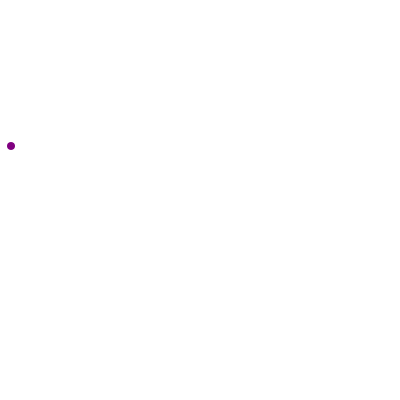

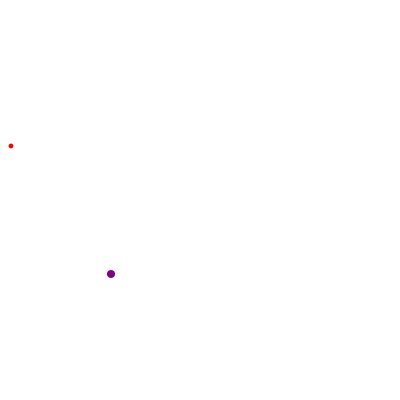

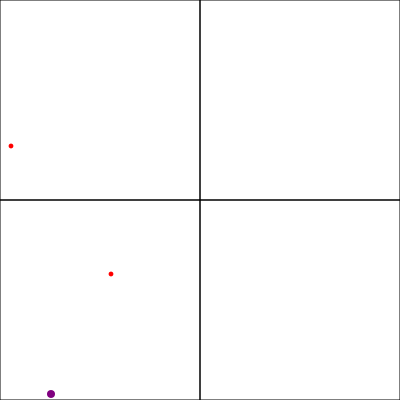

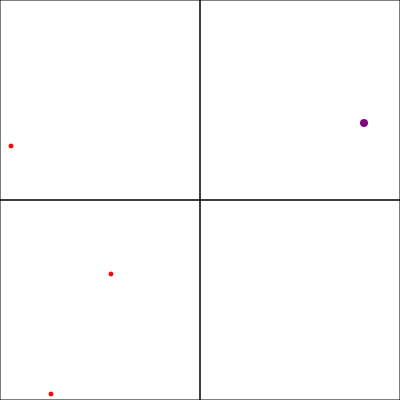

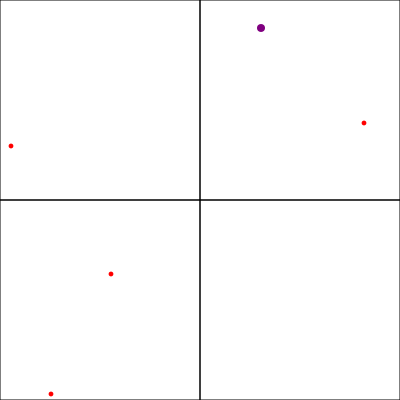

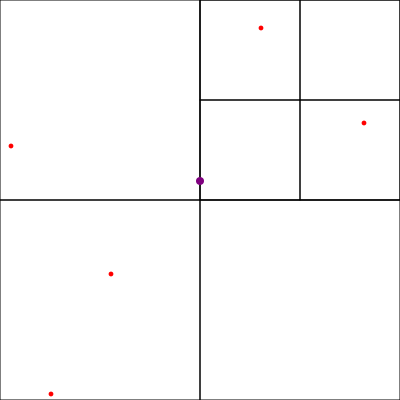

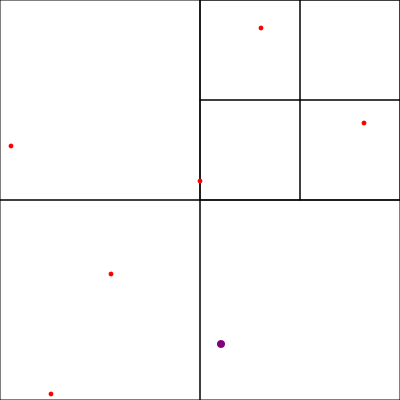

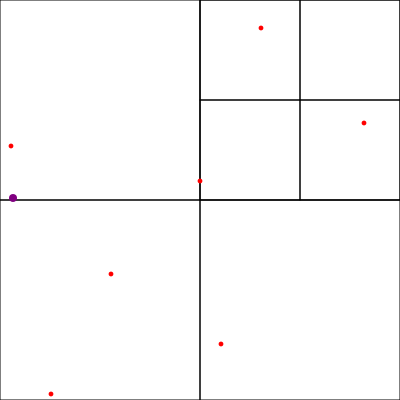

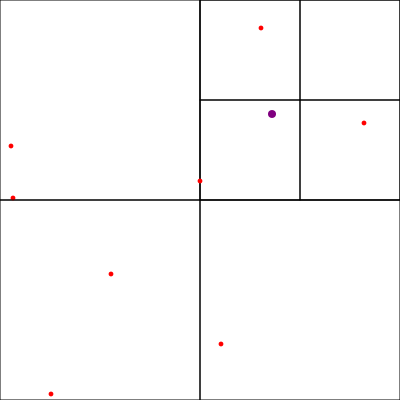

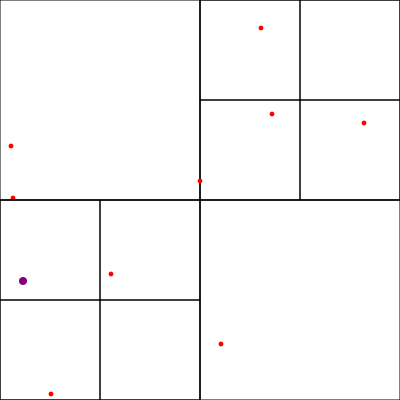

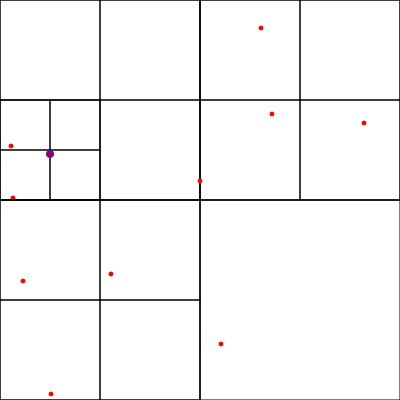

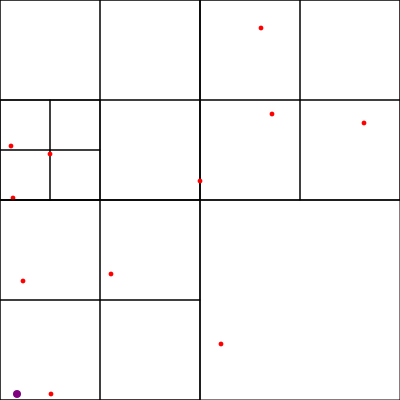

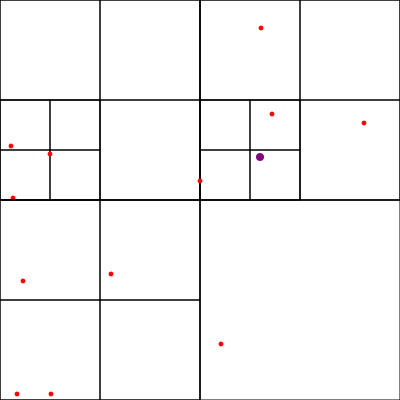

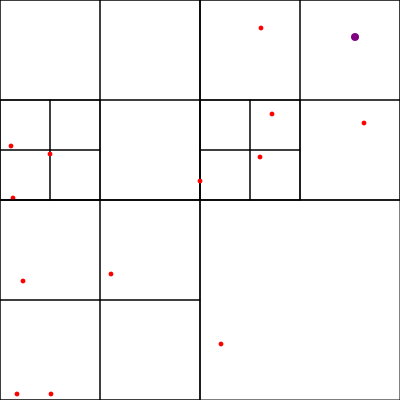

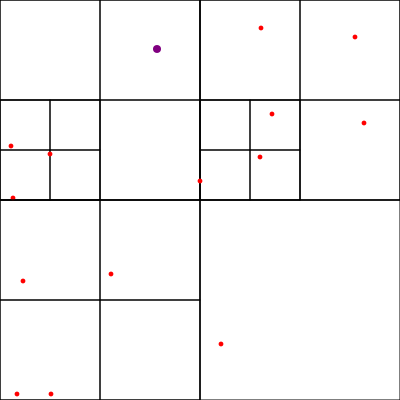

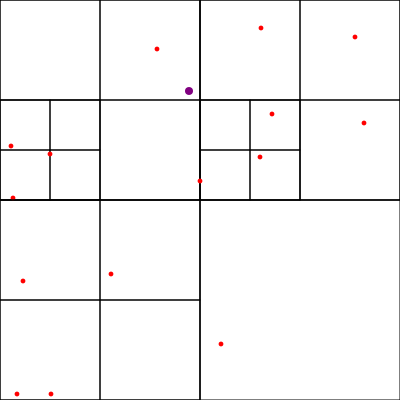

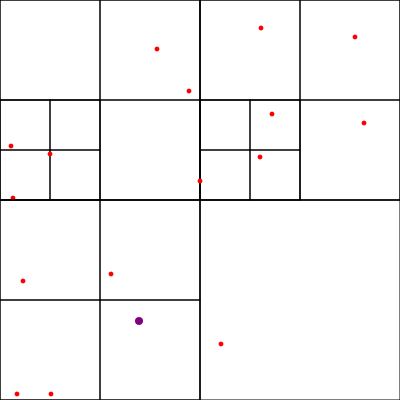

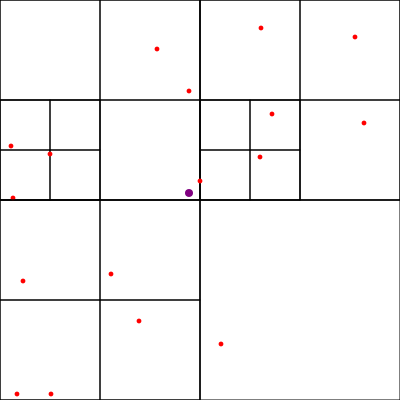

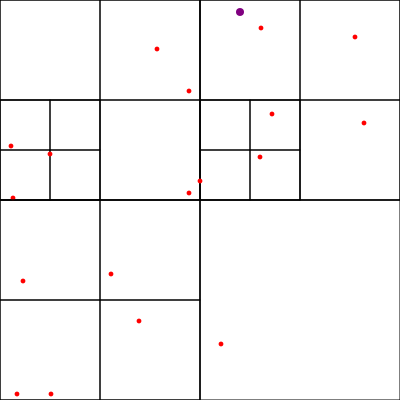

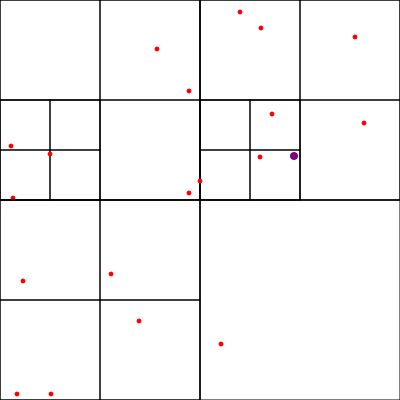

In [12]:
display(*gen_add_process(qs, gen_random_entries(20, W, H)))

<div dir=rtl>

### جستجو

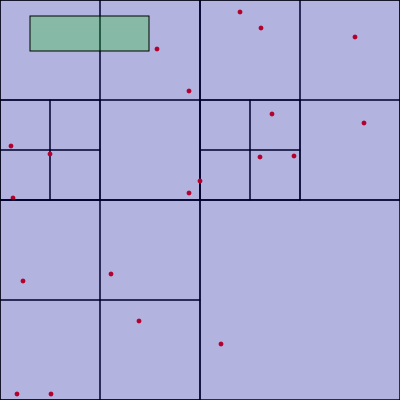

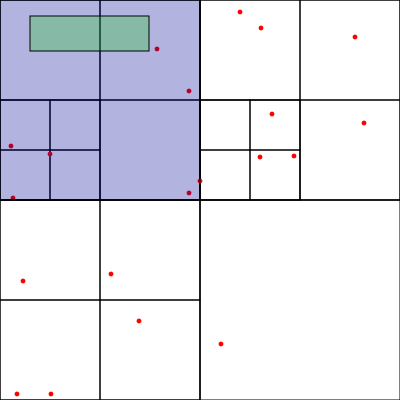

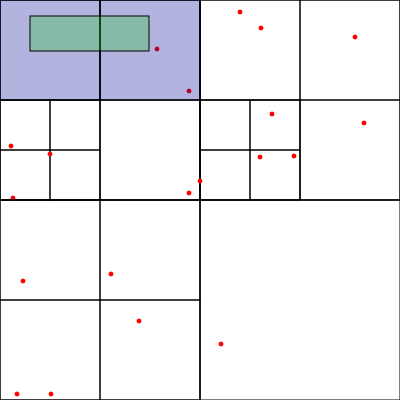

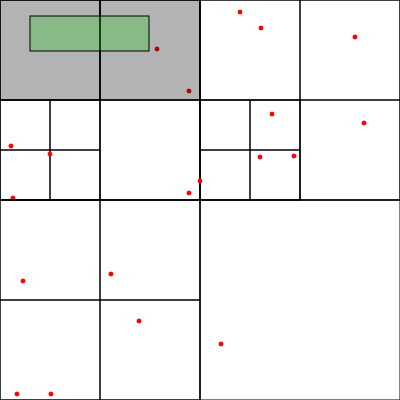

In [13]:
query = Geometry(
    randrange(0, int(W*2/3)), randrange(0, int(H*2/3)),
    randrange(20, int(W/3)), randrange(20, int(H/3)))

display(*gen_search_process(qs, query))